In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 


In [4]:
######## 读取数据 ########
sheet = pd.read_excel('data_input/日均铁水产量超季节性_3年.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')

last_day = sheet['日均铁水产量超季节性/3年'].last_valid_index()
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=5, freq='W-FRI')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='W-FRI')
sheet.head()


,日均铁水产量超季节性/3年,日均铁水产量
Date,,
2012-08-03,NaN,196.45
2012-08-10,NaN,194.87
2012-08-17,NaN,194.70
2012-08-24,NaN,193.89
2012-08-31,NaN,193.25


In [5]:

# 将日均铁水产量转化为日度数据
# 1. 确保日期列为日期格式
df = sheet[['日均铁水产量']].copy()
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna(subset=['日均铁水产量'])      # 删掉产量本身就是 NaN 的行（可选）
df = df[~df.index.isna()]                  # 删掉索引解析失败→NaT 的行

# 2. 生成完整的日期序列
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')

# 3. 重新索引并进行线性插值
df = df.reindex(full_idx)
df['日均铁水产量'] = df['日均铁水产量'].interpolate(method='linear')
#去掉闰年 2 月 29 日 
df = df[~((df.index.month == 2) & (df.index.day == 29))]
# -- 4) 去掉开头全 NaN 的“幽灵段” -------------------------------
first_valid = df['日均铁水产量'].first_valid_index()
df = df.loc[first_valid:]                  # 保留从首个有效值开始的所有行


In [6]:
df.tail()

,日均铁水产量
2025-10-20,240.50
2025-10-21,240.35
2025-10-22,240.20
2025-10-23,240.05
2025-10-24,239.90


In [7]:
file_path1 = os.path.expanduser("eta/日均铁水产量_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-12-01,238.9225
3,2025-12-02,236.2968
2,2025-12-03,235.4433
1,2025-12-04,235.5804
0,2025-12-05,236.1259


In [8]:
# ---------- 0. 确保 df 的索引是 DatetimeIndex -----------------------
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors='coerce')

# ---------- 1. 处理 sheet1：日期设为索引 ---------------------------
pred = sheet1[['Date', '预测值']].copy()
pred['Date'] = pd.to_datetime(pred['Date'], errors='coerce')
pred = pred.set_index('Date')

# ---------- 2. 只保留 df 之后的预测（防止重叠） --------------------
last_actual_date = df.index.max()            # df 最后一行的日期
pred = pred[pred.index > last_actual_date]   # 只要未来日期

# ---------- 3. 列名统一（可选）------------------------------------
pred.rename(columns={'预测值': '日均铁水产量'}, inplace=True)
# ---------- 4. 拼接：历史 + 未来 -----------------------------------
df = pd.concat([df, pred])
df = df.sort_index()                    # 防止时间轴乱序

# ---------------- 2. 重建完整日历 ---------------------------------
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')

# ---------------- 3. 补缺 & 线性插值 ------------------------------
df = df.reindex(full_idx)               # 把 05-03、05-04 也放进索引
df['日均铁水产量'] = df['日均铁水产量'].interpolate(method='linear')
df

,日均铁水产量
2012-08-03,196.450000
2012-08-04,196.224286
2012-08-05,195.998571
2012-08-06,195.772857
2012-08-07,195.547143
...,...
2025-12-01,238.922500
2025-12-02,236.296800
2025-12-03,235.443300
2025-12-04,235.580400


In [9]:
VALUE_COL   = '日均铁水产量'
N_YEARS     = 3                              # 往前追溯年数
ANOM_COL    = f'{VALUE_COL}超季节性_{N_YEARS}年_预测'

# --- 1. 计算每一年的同期值 ----------------------------------------
# 计算过去1年和2年的同期值
lag_1y = df[VALUE_COL].shift(365)  # 去年同期
lag_2y = df[VALUE_COL].shift(365*2)  # 前年同期

# --- 2. 计算同期平均值 -------------------------------------------
seasonal_mean = (df[VALUE_COL] + lag_1y + lag_2y) / 3  # 当年和过去两年的平均值

# --- 3. 计算"超季节性"值 -----------------------------------------
df[ANOM_COL] = df[VALUE_COL] - seasonal_mean  # 现值减去过去两年平均值

# （可选）保存同期平均值便于检查
df[f'{VALUE_COL}_过去{N_YEARS}年同期均'] = seasonal_mean

df

,日均铁水产量,日均铁水产量超季节性_3年_预测,日均铁水产量_过去3年同期均
2012-08-03,196.450000,NaN,NaN
2012-08-04,196.224286,NaN,NaN
2012-08-05,195.998571,NaN,NaN
2012-08-06,195.772857,NaN,NaN
2012-08-07,195.547143,NaN,NaN
...,...,...,...
2025-12-01,238.922500,3.540238,235.382262
2025-12-02,236.296800,2.095010,234.201790
2025-12-03,235.443300,1.831248,233.612052
2025-12-04,235.580400,2.227886,233.352514


In [10]:

# 合并 sheet
merged = (df
          .merge(sheet[['日均铁水产量超季节性/3年']],
                 left_index=True,
                 right_index=True,
                 how='left',
                 suffixes=('', '_from_sheet'))
         )
merged['日均铁水产量超季节性/3年'] = (
    merged['日均铁水产量超季节性_3年_预测']
    .combine_first(merged['日均铁水产量超季节性/3年'])
)
merged = merged.drop(
    columns=['日均铁水产量超季节性_3年_预测',
             '日均铁水产量','日均铁水产量_过去3年同期均']  
)
merged

,日均铁水产量超季节性/3年
2012-08-03,NaN
2012-08-04,NaN
2012-08-05,NaN
2012-08-06,NaN
2012-08-07,NaN
...,...
2025-12-01,3.540238
2025-12-02,2.095010
2025-12-03,1.831248
2025-12-04,2.227886


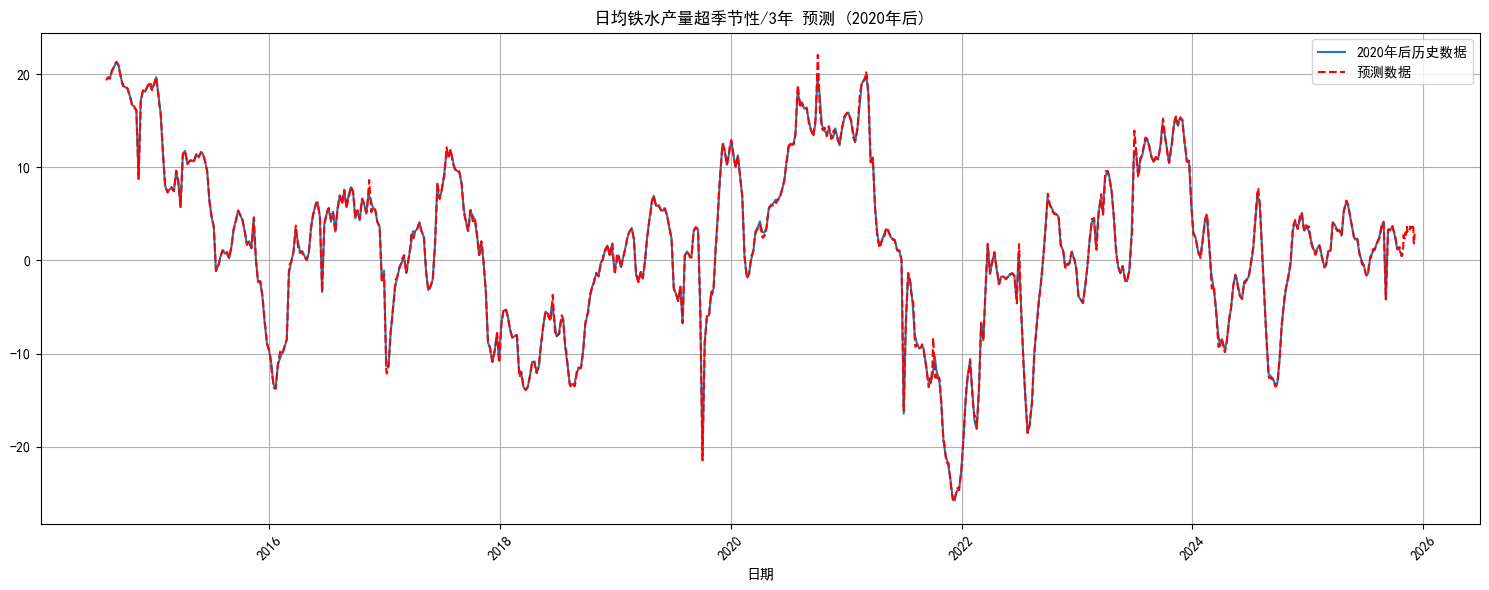

,Date,日均铁水产量超季节性/3年_预测
4831,2025-10-25,0.473810
4832,2025-10-26,0.470476
4833,2025-10-27,0.544286
4834,2025-10-28,1.132029
4835,2025-10-29,1.197571
4836,2025-10-30,1.459581
4837,2025-10-31,2.725990
4838,2025-11-01,2.560733
4839,2025-11-02,2.452143
4840,2025-11-03,2.407838


In [11]:

# 筛选2020年之后的数据
from heapq import merge


merged = merged.reset_index().rename(columns={'index': 'Date'})
sheet= sheet.reset_index().rename(columns={'index': 'Date'})
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']
# 获取当前时间
now = pd.Timestamp.now()

# 获取sheet_2020的最新时间
latest_date = sheet_2020['Date'].max()

# 筛选最新时间之后的数据
future_data = merged[merged['Date'] > latest_date]

future_df = pd.DataFrame({
    'Date': future_data['Date'],
    '日均铁水产量超季节性/3年_预测': future_data['日均铁水产量超季节性/3年']
})
# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet['Date'], sheet['日均铁水产量超季节性/3年'], label='2020年后历史数据')
plt.plot(merged['Date'], merged['日均铁水产量超季节性/3年'], 'r--', label='预测数据')
plt.title('日均铁水产量超季节性/3年 预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
future_df

In [12]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '日均铁水产量超季节性/3年']]
latest_date = sheet_2020['Date'].max()
merged = merged[merged['Date'] > latest_date]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged[['Date', '日均铁水产量超季节性/3年']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 重命名列名
merged_df_shizhi = merged_df_shizhi.rename(columns={'日均铁水产量超季节性/3年': '预测值'})

merged_df_shizhi.to_excel('eta/日均铁水产量超季节性3年_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,预测值
187,2025/12/05,NaN,2.896790
186,2025/12/04,NaN,2.227886
185,2025/12/03,NaN,1.831248
184,2025/12/02,NaN,2.095010
183,2025/12/01,NaN,3.540238
...,...,...,...
4,2023/02/03,-0.7705,NaN
3,2023/01/27,-2.8200,NaN
2,2023/01/20,-4.5724,NaN
1,2023/01/13,-4.2081,NaN


In [13]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_shizhi = monthly_df_shizhi.rename(columns={'日均铁水产量超季节性/3年': '预测值'})
monthly_df_shizhi.to_excel('eta/日均铁水产量超季节性3年_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,预测值
0,2025/12/31,NaN,2.896790
1,2025/11/30,NaN,3.531467
2,2025/10/31,0.5648,2.725990
3,2025/09/30,3.6924,NaN
4,2025/08/31,4.1729,NaN


---

---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铁矿_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "日均铁水产量超季节性3年"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.铁矿_数据上传.xlsx"
sheet_name = "详情页"
identifier = "日均铁水产量超季节性3年"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [16]:
count_prediction = merged_df_shizhi.copy()
# 将实际值和预测值合并为一列
count_prediction['预测叠加'] = count_prediction['实际值'].fillna(count_prediction['预测值'])
# 将日期列转换为datetime格式
count_prediction['Date'] = pd.to_datetime(count_prediction['Date'])
# 设置日期为索引
count_prediction.set_index('Date', inplace=True)
# 获取每月最后一天的数据
count_monthly_data = count_prediction.resample('ME').last()
# 重置索引并格式化日期
count_monthly_data = count_monthly_data.reset_index()
count_monthly_data['Date'] = count_monthly_data['Date'].dt.strftime('%Y/%m/%d')
# 显示结果
print(count_monthly_data[['Date', '预测叠加']].tail())

          Date      预测叠加
31  2025/08/31  4.172900
32  2025/09/30  3.692400
33  2025/10/31  2.725990
34  2025/11/30  3.531467
35  2025/12/31  2.896790